In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import time
import scipy
import cartopy
import xarray as xr
import argopy 
import seaborn as sns
import calendar

In [4]:
# Define region and load data into csv file
BOX=[87, 92, 12, 17, 0, 2000, '2015-10-01', '2024-09-30'] # Shifted small area a bit south-east 
ArgoSet = argopy.DataFetcher().region(BOX) 
df_raw = ArgoSet.data.argo.point2profile().to_dataframe() # Fetch Argo data
df = df_raw.dropna(subset=['TEMP', 'PRES', 'PSAL']) # Remove rows with NaN values
df = df[(df['PSAL_QC'] == 1) & (df['TEMP_QC'] == 1) & (df['PRES_QC'] == 1)] # Keep only rows where QC=1
df.to_csv('2015-2024-small-area.csv') # Write to csv

In [5]:
def load_csv():
    # Load the data from the CSV file
    data = pd.read_csv('2015-2024-small-area.csv')
    return data

def filter_one_float(data):
    # Filter data for one specific float (e.g., PLATFORM_NUMBER 2902766)
    float_data = data[data['PLATFORM_NUMBER'] == 2902192]
    return float_data

In [6]:
all_data = load_csv()
# data = filter_one_float(all_data) #work with one float
data=all_data #work with all floats

print(data['TIME'].min())
print(data['TIME'].max())

# Get PLATFORM_NUMBER counts in decreasing order
platform_counts = all_data['PLATFORM_NUMBER'].value_counts()
print(platform_counts.head())# based on this, we pick the most frequently occurring float

# Define the pressure bins and labels
# Create pressure bins from 0 to max pressure
max_pressure = data['PRES'].max()
print('Max pressure over the selected period is '+str(max_pressure)+' dbar')
pressure_bins = np.concatenate((np.arange(0, 10, 2),
                                np.arange(10, 100 , 10), 
                                np.arange(100, max_pressure + 25, 25)))
# Assign each row to a pressure bin and create pressure bin column
data['PRES_BIN'] = pd.cut(data['PRES'], bins=pressure_bins, labels=pressure_bins[:-1])

data['TIME'] = pd.to_datetime(data['TIME']) # Convert 'TIME' to datetime if it's not already
data['MONTH'] = data['TIME'].dt.month # Assign each row to a calendar month
data.set_index('TIME', inplace=True) # Set 'TIME' as the index for resampling

2015-10-02 21:57:10
2024-09-25 14:19:53
PLATFORM_NUMBER
2902192    132180
2902234     59141
2902235     57538
5904302     42817
2902160     40936
Name: count, dtype: int64
Max pressure over the selected period is 2000.4 dbar


In [ ]:
# print("data : ")
# print(data.head())

In [7]:
# Monthly resampled data
resampled_data = data.groupby('PRES_BIN', observed=True).resample('M').agg(
    avg_temp=('TEMP', 'mean'),
    avg_salinity=('PSAL', 'mean')
)
resampled_data.reset_index(inplace=True)
resampled_data['YEAR'] = resampled_data['TIME'].dt.year
resampled_data['MONTH'] = resampled_data['TIME'].dt.month

data.reset_index(); # reset index

/var/folders/2w/tdn42d6s2lx6l_8md1rzw46r0000gn/T/ipykernel_1711/2036427295.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_data = data.groupby('PRES_BIN', observed=True).resample('M').agg(


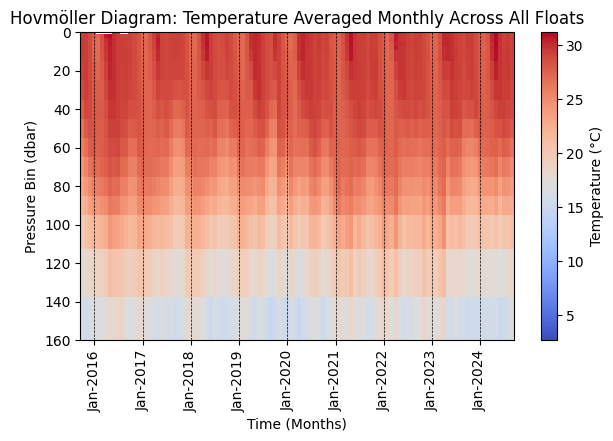

In [10]:
# Plot T hovmoller diagram 
hovmoller_data = resampled_data.pivot(index='PRES_BIN', columns='TIME', values='avg_temp') # Pivot the data to have TIME on the columns and PRES_BIN on the rows
hovmoller_data.columns = pd.to_datetime(hovmoller_data.columns)

plt.figure(figsize=(7, 4))
plt.pcolormesh(hovmoller_data.columns, hovmoller_data.index, hovmoller_data.values, shading='auto', cmap='coolwarm')

for date in hovmoller_data.columns:
    if date.month == 1:
        plt.axvline(x=date, color='k', linestyle='--', linewidth=0.5)  # Add dashed vertical line

plt.colorbar(label='Temperature (°C)')
plt.gca().invert_yaxis()  # Invert y-axis to have surface at the top
plt.xlabel('Time (Months)')
plt.ylabel('Pressure Bin (dbar)')
plt.title('Hovmöller Diagram: Temperature Averaged Monthly Across All Floats')
plt.xticks(rotation=90)
january_dates = [date for date in hovmoller_data.columns if date.month == 1]
plt.xticks(ticks=january_dates, labels=[date.strftime('%b-%Y') for date in january_dates], rotation=90)
plt.ylim(160,0)

plt.show()

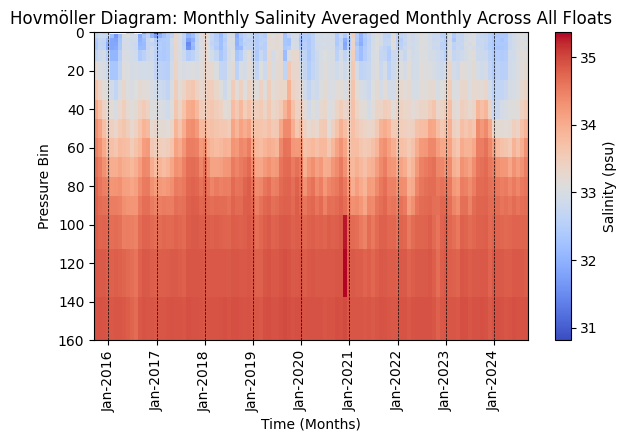

In [11]:
# Plot S hovmoller diagram
hovmoller_data = resampled_data.pivot(index='PRES_BIN', columns='TIME', values='avg_salinity')# Pivot the data to have TIME on the columns and PRES_BIN on the rows
hovmoller_data.columns = pd.to_datetime(hovmoller_data.columns)

plt.figure(figsize=(7, 4))
plt.pcolormesh(hovmoller_data.columns, hovmoller_data.index, hovmoller_data.values, shading='auto', cmap='coolwarm')

for date in hovmoller_data.columns:
    if date.month == 1:
        plt.axvline(x=date, color='k', linestyle='--', linewidth=0.5)  # Add dashed vertical line


plt.colorbar(label='Salinity (psu)')
plt.gca().invert_yaxis()  # Invert y-axis to have surface at the top
plt.xlabel('Time (Months)')
plt.ylabel('Pressure Bin')
plt.title('Hovmöller Diagram: Monthly Salinity Averaged Monthly Across All Floats')
plt.xticks(rotation=90)
january_dates = [date for date in hovmoller_data.columns if date.month == 1]
plt.xticks(ticks=january_dates, labels=[date.strftime('%b-%Y') for date in january_dates], rotation=90)
plt.ylim(160,0)

plt.show()

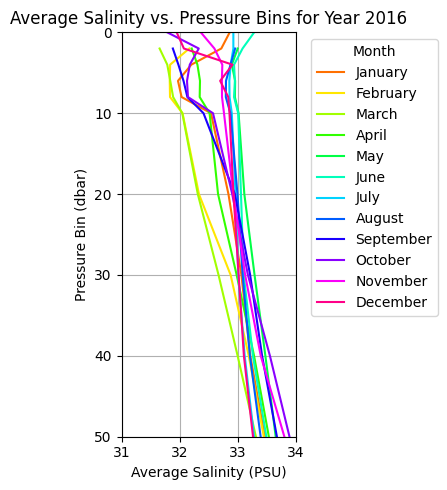

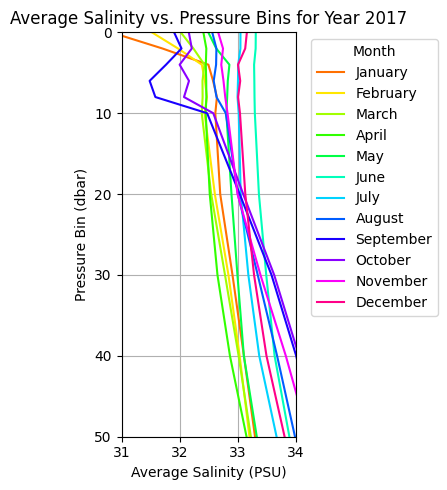

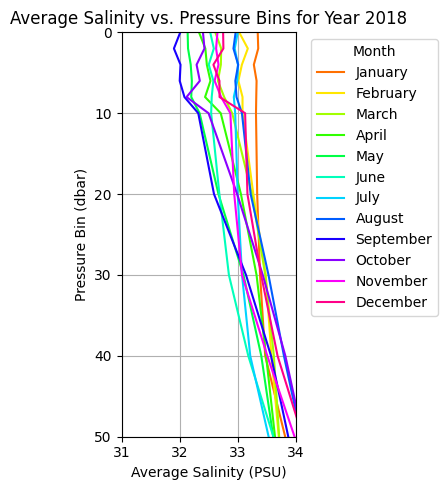

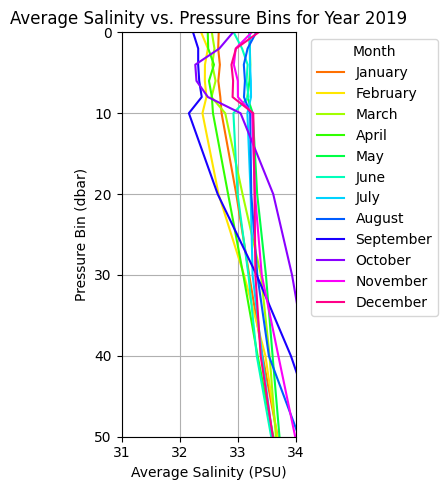

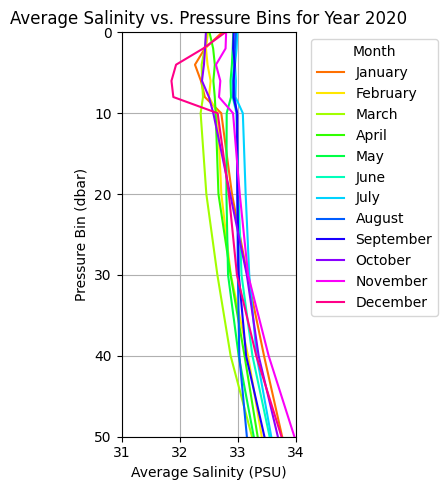

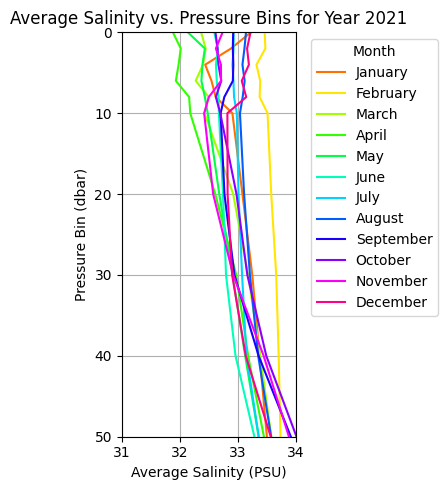

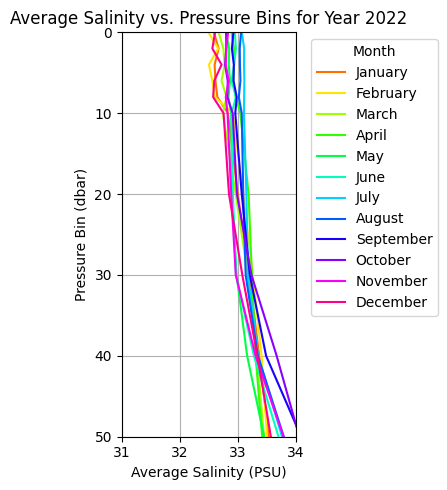

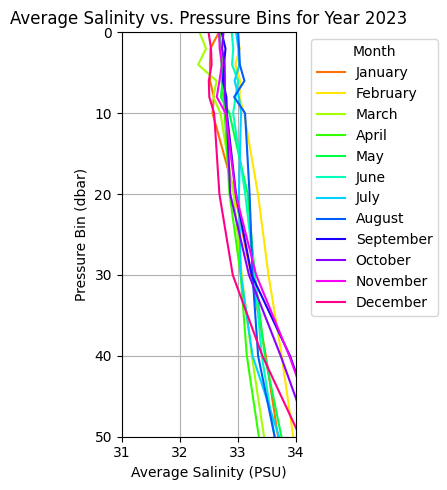

In [ ]:
# Plot T and S monthly bin-averaged profiles per year
rainbow_palette = sns.color_palette("hsv", 12)  # Use same color palette as further down

for year in np.arange(2016,2024,1):
    # Filter data for the current year
    yearly_data = resampled_data[resampled_data['YEAR'] == year]

    plt.figure(figsize=(4, 5))
    plt.gca().invert_yaxis()  # Invert y-axis to have deeper pressure at the bottom

    # Plot one line per month
    for month in range(1, 13):
        monthly_data = yearly_data[yearly_data['MONTH'] == month]
        if not monthly_data.empty:
            plt.plot(monthly_data['avg_salinity'], monthly_data['PRES_BIN'],
                     label=calendar.month_name[month], linestyle='-', color=rainbow_palette[month - 1])

    # Add plot details
    plt.xlabel('Average Salinity (PSU)')
    plt.ylabel('Pressure Bin (dbar)')
    plt.title(f'Monthly Average Salinity vs. Pressure Bins for Year {year}')
    plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylim(50,0)
    plt.xlim(31,34)

    plt.grid()
    plt.tight_layout()

In [13]:
# Calendar-month averaged data
cal_month_avg_data = (
    data.groupby(['PRES_BIN', 'MONTH'])[['TEMP', 'PSAL']]
    .mean()
    .reset_index()
)
cal_month_avg_data['MONTH'] = cal_month_avg_data['MONTH'].map({
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}) # Optionally, replace numeric months with month names

/var/folders/2w/tdn42d6s2lx6l_8md1rzw46r0000gn/T/ipykernel_1711/3299265498.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(['PRES_BIN', 'MONTH'])[['TEMP', 'PSAL']]


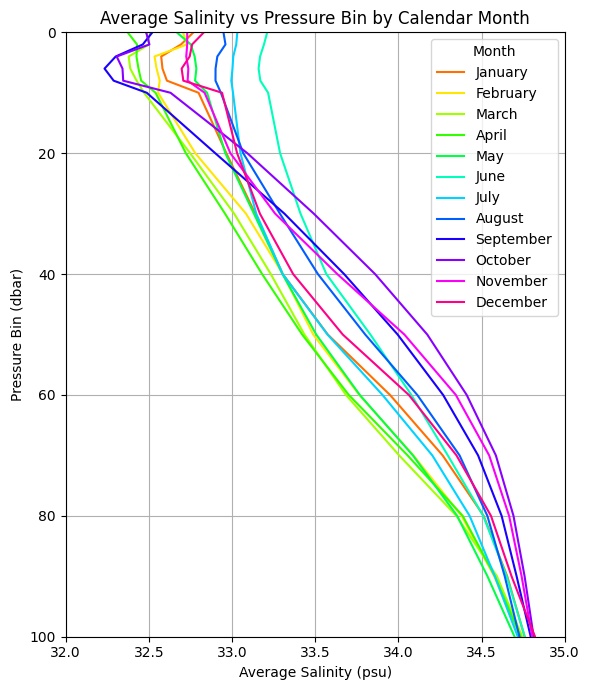

In [27]:
# Pivot the data for easier plotting
pivoted = cal_month_avg_data.pivot(index='PRES_BIN', columns='MONTH', values='PSAL')

# Sort months explicitly for consistent order and create color palette
sorted_months = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]
rainbow_palette = sns.color_palette("hsv", 12)
colors = dict(zip(sorted_months, rainbow_palette))

# Plotting
fig, ax = plt.subplots(figsize=(6, 7))
dy=1
for month in sorted_months:
    ax.plot(
        pivoted[month],
        pivoted.index,
        label=month,
        color=colors[month]
    )
    
    # # Add text labels next to some months (e.g., the last data point of each month)
    # if month in [ 'June', 'July', 'August', 'September']:  # Customize which months to label
    #     x_val = pivoted[month].iloc[0]  # Last x-value (temperature)
    #     y_val = pivoted.index[0]  # Last y-value (pressure bin)
    #     ax.text(
    #         x_val,  # Offset text slightly to the right
    #         y_val + dy, 
    #         month, 
    #         color=colors[month], 
    #         fontsize=10, 
    #         fontweight='bold'
    #     )
    #     dy=dy+1

# Reverse the y-axis for depth
ax.invert_yaxis()

# Add labels, title, and legend
ax.set_xlabel('Average Salinity (psu)')
ax.set_ylabel('Pressure Bin (dbar)')
ax.set_title('Average Salinity vs Pressure Bin by Calendar Month')
ax.set_ylim(100,0)
ax.set_xlim(32,35)
# Sort the legend by the predefined order
handles, labels = ax.get_legend_handles_labels()
sorted_handles_labels = sorted(zip(labels, handles), key=lambda x: sorted_months.index(x[0]))
sorted_labels, sorted_handles = zip(*sorted_handles_labels)
ax.legend(sorted_handles, sorted_labels, title='Month', loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()

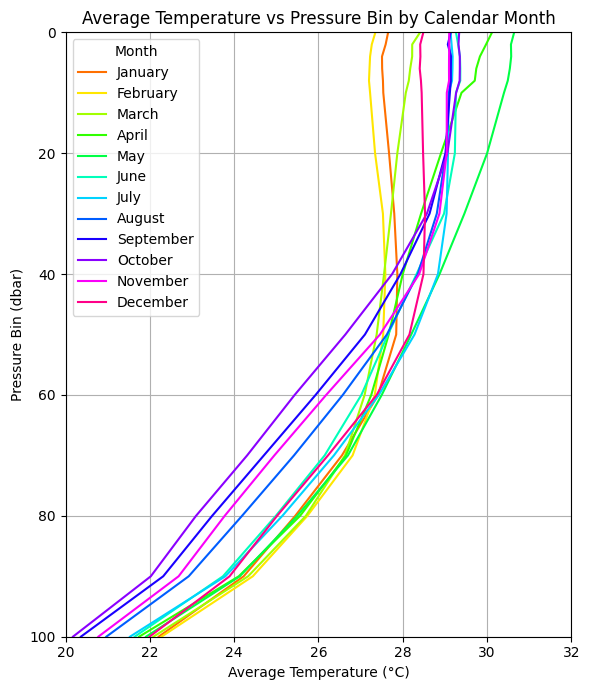

In [28]:
# Pivot the data for easier plotting
pivoted = cal_month_avg_data.pivot(index='PRES_BIN', columns='MONTH', values='TEMP')

# Sort months explicitly for consistent order and create color palette
sorted_months = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]
rainbow_palette = sns.color_palette("hsv", 12)
colors = dict(zip(sorted_months, rainbow_palette))

# Plotting
fig2, ax2 = plt.subplots(figsize=(6, 7))
dy=0.5
for month in sorted_months:
    ax2.plot(
        pivoted[month],
        pivoted.index,
        label=month,
        color=colors[month]
    )

    # # Add text labels next to some months (e.g., the last data point of each month)
    # if month in ['February', 'April', 'May', 'June','November']:  # Customize which months to label
    #     x_val = pivoted[month].iloc[0]  # Last x-value (temperature)
    #     y_val = pivoted.index[0]  # Last y-value (pressure bin)
    #     ax2.text(
    #         x_val,  # Offset text slightly to the right
    #         y_val + dy, 
    #         month, 
    #         color=colors[month], 
    #         fontsize=10, 
    #         fontweight='bold'
    #     )
    #     dy=dy+0.5

# Reverse the y-axis for depth
ax2.invert_yaxis()

# Add labels, title, and legend
ax2.set_xlabel('Average Temperature (°C)')
ax2.set_ylabel('Pressure Bin (dbar)')
ax2.set_title('Average Temperature vs Pressure Bin by Calendar Month')
ax2.set_ylim(100,0)
ax2.set_xlim(20,32)
# Sort the legend by the predefined order
handles, labels = ax.get_legend_handles_labels()
sorted_handles_labels = sorted(zip(labels, handles), key=lambda x: sorted_months.index(x[0]))
sorted_labels, sorted_handles = zip(*sorted_handles_labels)
ax2.legend(sorted_handles, sorted_labels, title='Month', loc='upper left')

plt.grid(True)
plt.tight_layout()
plt.show()